In [15]:
import time
from typing import Optional, Tuple, List, Dict
import colorsys

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [16]:
torch.cuda.is_available()

True

In [17]:
torch.__version__

'1.13.1+cu117'

In [18]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [19]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str = 'cuda') -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=4096,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [20]:
class MyConvModel(nn.Module):
    def __init__(self, channels: int, use_bn: bool, activation: nn.Module):
        super().__init__()

        self.use_bn: bool = use_bn
        self.activation: nn.Module = activation

        c = channels
        self.layers = nn.Sequential(
            *self.conv(1, c, kernel_size=3),  # 28 - 26
            *self.conv(c, c, kernel_size=3),  # 26 - 24
            nn.MaxPool2d(2),  # 24 - 12

            *self.conv(c, c * 2, kernel_size=3),  # 12 - 10
            *self.conv(c * 2, c * 2, kernel_size=3),  # 10 - 8
            nn.MaxPool2d(2),  # 8 - 4

            *self.conv(c * 2, c * 4, kernel_size=3),  # 4 - 2
            *self.conv(c * 4, c * 4, kernel_size=2),  # 2 - 1

            nn.Conv2d(c * 4, 10, kernel_size=1, padding='valid', bias=True),
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size) -> List[nn.Module]:
        if self.use_bn:
            return [
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
                nn.BatchNorm2d(out_ch),
                self.activation
            ]
        return [
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=True),
            self.activation
        ]

    def forward(self, x: torch.Tensor):
        return self.layers(x)
    
    @staticmethod
    def activations() -> Dict[str, nn.Module]:
        return {
            'relu': nn.ReLU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'elu': nn.ELU(),
            'silu': nn.SiLU(),
            'gelu': nn.GELU(),
            'mish': nn.Mish(),
            'softplus': nn.Softplus(),
            'sigmoid': nn.Tanh(),
        }

In [21]:
def run_networks(use_bn: bool, repeats: int = 1) -> Dict[str, List[Tuple[int, int]]]:
    results = {}
    
    for name, activation in MyConvModel.activations().items():
        if name not in results:
            results[name] = []
        for i in range(repeats):
            print(f'start train network with {name}, repeat {i}')
            models = [MyConvModel(n, use_bn=use_bn, activation=activation) for n in [8, 12, 16, 24, 32]]
            
            for pair in TrainHelper.train_models(models):
                results[name].append(pair)
            
    return results

results_with_bn = run_networks(use_bn=True)

start train network with relu, repeat 0
best accuracy = 0.9904, parameters = 13362, training time = 90.27944564819336
best accuracy = 0.9939, parameters = 29590, training time = 90.18729901313782
best accuracy = 0.9945, parameters = 52186, training time = 91.12096214294434
best accuracy = 0.9951, parameters = 116482, training time = 90.93356013298035
best accuracy = 0.9949, parameters = 206250, training time = 92.35794186592102
start train network with leaky_relu, repeat 0
best accuracy = 0.9905, parameters = 13362, training time = 93.4674642086029
best accuracy = 0.9927, parameters = 29590, training time = 92.205570936203
best accuracy = 0.994, parameters = 52186, training time = 93.23203206062317
best accuracy = 0.994, parameters = 116482, training time = 92.63798117637634
best accuracy = 0.9951, parameters = 206250, training time = 89.46953082084656
start train network with elu, repeat 0
best accuracy = 0.9893, parameters = 13362, training time = 88.33885097503662
best accuracy = 0.

relu color=(1.0, 0.0, 0.0)
leaky_relu color=(1.0, 0.6000000000000001, 0.0)
elu color=(0.7999999999999998, 1.0, 0.0)
silu color=(0.19999999999999973, 1.0, 0.0)
gelu color=(0.0, 1.0, 0.40000000000000036)
mish color=(0.0, 1.0, 1.0)
softplus color=(0.0, 0.39999999999999947, 1.0)
sigmoid color=(0.20000000000000018, 0.0, 1.0)


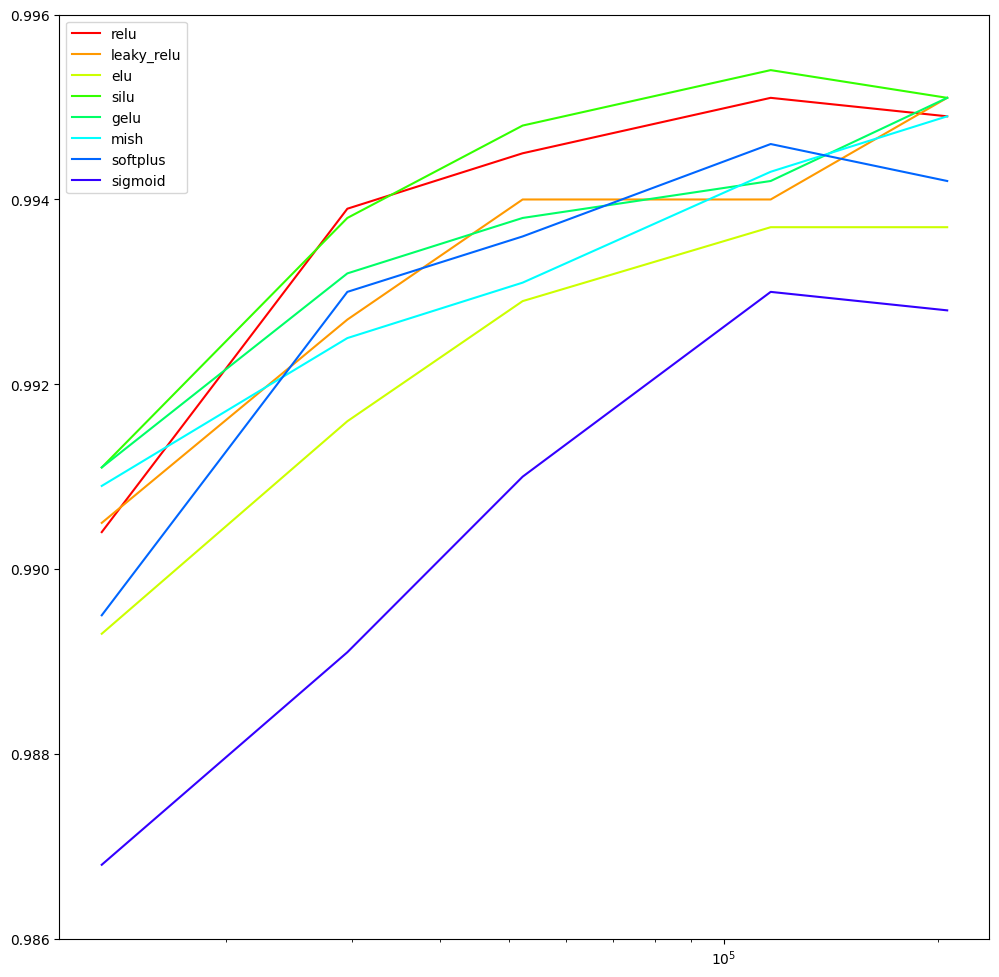

In [30]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.986, 0.996)

for i, (name, results) in enumerate(results_with_bn.items()):
    params_counts = [p[0] for p in results]
    accuracies = [p[1] for p in results]

    color = colorsys.hsv_to_rgb(i * 0.1, 1.0, 1.0)
    print(f"{name} color={color}")
    ax.plot(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()

In [23]:
results_no_bn = run_networks(use_bn=False)

start train network with relu, repeat 0
best accuracy = 0.9705, parameters = 13250, training time = 86.03410243988037
best accuracy = 0.9719, parameters = 29422, training time = 85.99633264541626
best accuracy = 0.9787, parameters = 51962, training time = 85.71026492118835
best accuracy = 0.9872, parameters = 116146, training time = 85.97603869438171
best accuracy = 0.9873, parameters = 205802, training time = 85.7520923614502
start train network with leaky_relu, repeat 0
best accuracy = 0.9705, parameters = 13250, training time = 85.85710716247559
best accuracy = 0.979, parameters = 29422, training time = 86.05189990997314
best accuracy = 0.9818, parameters = 51962, training time = 85.92362952232361
best accuracy = 0.9871, parameters = 116146, training time = 85.68863296508789
best accuracy = 0.9897, parameters = 205802, training time = 86.0320041179657
start train network with elu, repeat 0
best accuracy = 0.9757, parameters = 13250, training time = 85.9117329120636
best accuracy = 0

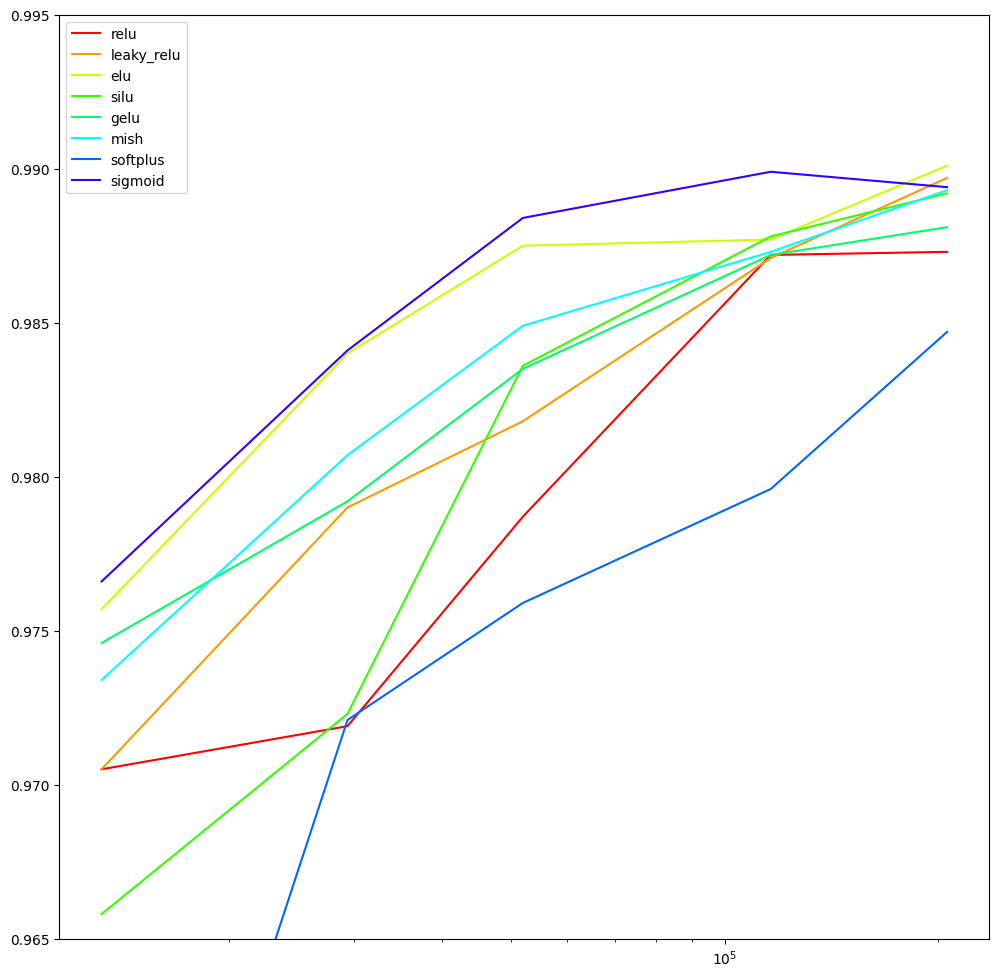

In [32]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.965, 0.995)

for i, (name, results) in enumerate(results_no_bn.items()):
    params_counts = [p[0] for p in results]
    accuracies = [p[1] for p in results]

    color = colorsys.hsv_to_rgb(i * 0.1, 1.0, 1.0)
    ax.plot(params_counts, accuracies, c=color, label=name)

ax.legend()
plt.show()